##Pseudocode
1. **Import modules:** `math`, `numpy`, `solve_ivp` from `scipy.integrate`, `pyplot` and `animate` from `matplotlib`
2. **Define equation of motion:** $$\ddot{\theta}+2 \gamma \dot{\theta}+\omega_0^2 sin\theta-\omega_d^2 \frac{x_{p0}}{l} cos\omega_d t sin\theta +\omega_d^2 \frac{y_{p0}}{l} sin\omega_d t cos\theta = 0$$  The general solution will be in the form $\theta_{guess} =\omega_dt + \epsilon$, where $\epsilon$ is very small, and allows for little movement of the mass around the center. $\bar{\epsilon}=sin^{-1}(2\gamma/\omega_d))$
3. **Define utilities:**  `create_pendulum_animation(x,x_pivot,y_pivot,...)` for creating the animation of the pivot, `basic_plot(x,y,x_label,...)` for plotting data.
4. **Define mathmatical functions:** `get_pivot_xy(t_plot, omega_d, x_p0, y_p0)` to determine the pivot's vector from the origin; `get_pendulum_xy(t_plot, theta_plot, l):` to determine vector from pivot point to the pendulum mass;  `get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum)` to determine position of the end of the pendulum relative to the lab's (0,0,0) perspective;
`pendulum_ode(t,y,omega_d,g,l,gamma,x_p0,y_p0)` sets up the differential equation to use with `solve_ivp`



In [1]:
#imported modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from IPython.display import HTML

In [2]:
#define utilities
def create_pendulum_animation(t, x_pivot, y_pivot, x_lab, y_lab, l=1, show_traj=False, speed_factor=1.0):
    """
    Creates an animation of the pivot-driven pendulum.

    PARAMETERS:
    t : ndarray
        Time array.
    x_pivot : ndarray
        x-positions of the pivot over time.
    y_pivot : ndarray
        y-positions of the pivot over time.
    x_lab : ndarray
        x-positions of the pendulum bob in the lab frame over time.
    y_lab : ndarray
        y-positions of the pendulum bob in the lab frame over time.
    l : float, optional
        pendulum length (default is 1).
    show_traj : bool, optional
        toggle showing the trajectory of the pendulum bob (default is False).
    speed_factor : float, optional
        factor to scale the animation speed (default is 1.0).
        a value > 1.0 slows down the animation, < 1.0 speeds it up.

    RETURNS:
    anim : FuncAnimation
        matplotlib animation object.
    """
    fig, ax = plt.subplots(figsize=(4, 4)) # Increased figure size
    ax.set_xlim(np.min(x_pivot) - l, np.max(x_pivot) + l)
    ax.set_ylim(np.min(y_pivot) - l, np.max(y_pivot) + l)
    # ax.set_aspect('equal', adjustable='box')
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Initialize plot elements
    pivot, = ax.plot([], [], 'o', color='black', markersize=8, label='Pivot')
    pendulum_arm, = ax.plot([], [], '-', color='black', lw=2, label='Pendulum Arm')
    pendulum_bob, = ax.plot([], [], 'o', color='red', markersize=12, label='Pendulum Bob')
    trajectory = None # Initialize trajectory to None

    if show_traj:
        trajectory, = ax.plot([], [], '-', color='gray', lw=1, alpha=0.5, label='Trajectory') # Add trajectory line

    def animate(i):
        # Update the positions of the plot elements
        pivot.set_data([x_pivot[i]], [y_pivot[i]]) # Pass as sequences
        pendulum_arm.set_data([x_pivot[i], x_lab[i]], [y_pivot[i], y_lab[i]])
        pendulum_bob.set_data([x_lab[i]], [y_lab[i]]) # Pass as sequences

        artists = [pivot, pendulum_arm, pendulum_bob] # List of artists to update

        if show_traj and trajectory:
             trajectory.set_data(x_lab[:i+1], y_lab[:i+1]) # Update trajectory data
             artists.append(trajectory) # Add trajectory to the list of artists

        return artists # Return all updated artists

    # Create the animation
    # Adjust the interval based on the average time step in t
    # This aims to make the animation speed consistent with the simulation time
    average_time_step = np.mean(np.diff(t))
    # Scale the interval by the speed_factor
    interval = average_time_step * 1000 * speed_factor # Convert to milliseconds and apply speed_factor.

    anim = FuncAnimation.FuncAnimation(fig, animate, frames=len(t), interval=interval, blit=True)
    plt.close(fig) # Close the initial figure to prevent it from displaying

    return anim
    # animate motion


def basic_plot(x,y,xlabel=None,ylabel=None,figsize=(3,3)): #plotting utility
  """
  Inputs:
    x -       domain
    y -       range
    ylabel - title for y axis
    figsize - size of the graph
  Returns:
    Matplotlib Graph
  """
  plt.figure(figsize=figsize)
  plt.plot(x,y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return plt.show()
#define functions
def pendulum_ode(t,y,omega_d,g,l,gamma,x_p0,y_p0):
  """
  Inputs:
  t -  domain
  y -  range
  omega_d - driving frequency
  g - gravity
  l - length of the pendulum
  gamma- dampening
  x_p0- x-pivot parameterization
  y_p0- y-pivot parameterization

  Returns:
  [dtheta_dt, d2theta_dt2]
  """
  omega_0_sq = g/l

  theta, ang_vel = y


  dtheta_dt = ang_vel
  d2theta_dt2 = -2*gamma*ang_vel - omega_0_sq*np.sin(theta) + \
                omega_d**2 * (x_p0/l) * np.cos(omega_d*t) * np.sin(theta) - \
                omega_d**2 * (y_p0/l) * np.sin(omega_d*t) * np.cos(theta)


  return [dtheta_dt, d2theta_dt2]
def get_pivot_xy(t_plot, omega_d, x_p0, y_p0):
  """
Inputs:
x_p0, y_p0: pivot parameterization
t_plot: array of time points
omega_d: driving frequency
Returns:
x_pivot, y_pivot: vector from (0,0,0) to pivot point

  """
  x_pivot = -x_p0 *np.sin(omega_d * t_plot)
  y_pivot = y_p0 * (np.cos(omega_d * t_plot)-1)
  return x_pivot, y_pivot
def get_pendulum_xy(t_plot, theta_plot, l):
  """
  Inputs:
  t_plot: array of time points
  theta_plot: array of theta
  l: length of pivot
  Returns:
  x_pendulum, y_pendulum: position of pendulum relative to pivot point
  """
  x_pendulum = l * np.sin(theta_plot)
  y_pendulum = -l * np.cos(theta_plot)

  return x_pendulum, y_pendulum
def get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum):
  """
  Inputs:
  x_pivot, y_pivot: spatial position of pivot point
  x_pendulum, y_pendulum: position of pendulum relative to pivot point
  Returns:
  x_lab,y_lab: spatial position of pendulum relative to lab frame
  """
  x_lab = x_pivot + x_pendulum
  y_lab = y_pivot + y_pendulum
  return x_lab, y_lab


In [60]:
#parameters
omega_d = 1.6
g = l = 1
gamma = .1
x_p0, y_p0 = 1, 1
n_cycles = 10

#time span as we know characteristic frequency
t_min = 0
t_max = n_cycles * 2 * np.pi / omega_d
t_span = [t_min,t_max]

#initial conditions
#1theta_0 = np.pi - np.arcsin(2*gamma / omega_d)
#ang_vel_0 = omega_d
theta_0 = 0
ang_vel_0 = 0
y_0 = [theta_0, ang_vel_0]

#solve the equation of motion
sol= solve_ivp(pendulum_ode, t_span, y_0, args=(omega_d,g,l,gamma,x_p0,y_p0), method = 'Radau', dense_output = True)


Text(0, 0.5, 'epsilon= theta-omega_d*t')

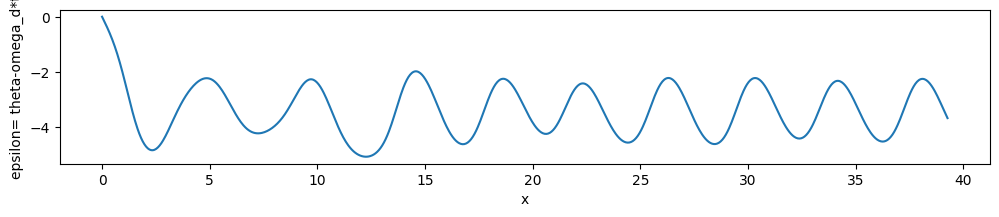

In [61]:
#plot pendulum angle vs time
t_plot = np.linspace(t_min,t_max,1000)
theta_plot = sol.sol(t_plot)[0]
ang_vel_plt = sol.sol(t_plot)[1]

#construct plot HAVE TICKS EVERY PI
plt.figure(figsize=(12,2))
plt.plot(t_plot,theta_plot - omega_d * t_plot)
#plt.ylim(-5*np.pi,5*np.pi)
plt.xlabel('x')
plt.ylabel('epsilon= theta-omega_d*t')


In [59]:
# plot pendulum angle versus time
# get coordinates for plotting
n_points = 300 # number of frames
t_plot = np.linspace(t_min, t_max, n_points)
theta_plot = sol.sol(t_plot)[0] # requires `dense_output=True` in `solve_ivp`
x_pivot, y_pivot = get_pivot_xy(t_plot, omega_d, x_p0, y_p0) # pivot coordinates
x_pendulum, y_pendulum = get_pendulum_xy(t_plot, theta_plot, l) # pendulum coordinates of pendulum (referenced to pivot point)
x_lab, y_lab = get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum) # pendulum coordinates in the lab frame

# animation flags/parameters
show_traj = True # True --> show trajectory; False --> do not show trajectory
speed_factor = 5 # >1 --> slow down animation; <1 --> speed up animation

# create_pendulum_animation
pendulum_animation = create_pendulum_animation(t_plot, x_pivot, y_pivot, x_lab, y_lab, show_traj=show_traj, speed_factor=speed_factor) # create animation object with trajectory shown
HTML(pendulum_animation.to_html5_video()) # display animation

3. We can say energy is represented by $\frac{\bar{u}}{\omega_d^2}=cos\bar{\epsilon} + \frac{2\gamma}{\omega_d}\bar{\epsilon}$, so we see by plotting $\frac{\bar{u}}{\omega_d^2}$ vs $\bar{\epsilon}$ that we found an unstable equilibrium point. Starting at $\theta = \pi- sin^{-1}(\frac{2\gamma}{\omega_d}) $, we are in the stable eqilibrium point.

In [42]:
#parameters
omega_d = 1.8
g = l = 1
gamma = .1
x_p0, y_p0 = 1, 1
n_cycles = 10

#time span as we know characteristic frequency
t_min = 0
t_max = n_cycles * 2 * np.pi / omega_d
t_span = [t_min,t_max]

#initial conditions
theta_0 = np.pi - np.arcsin(2*gamma / omega_d)
ang_vel_0 = omega_d
y_0 = [theta_0, ang_vel_0]

#solve the equation of motion
sol= solve_ivp(pendulum_ode, t_span, y_0, args=(omega_d,g,l,gamma,x_p0,y_p0), method = 'Radau', dense_output = True)


Text(0, 0.5, 'epsilon= theta-omega_d*t')

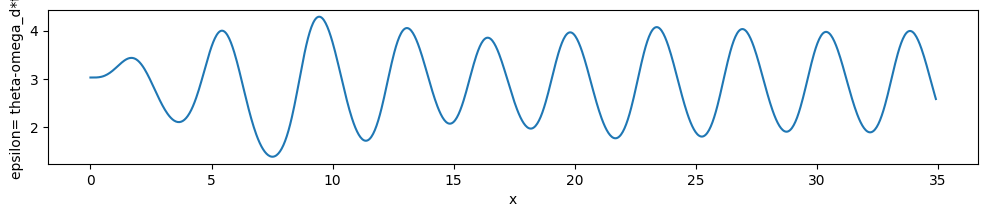

In [43]:
#plot pendulum angle vs time
t_plot = np.linspace(t_min,t_max,1000)
theta_plot = sol.sol(t_plot)[0]
ang_vel_plt = sol.sol(t_plot)[1]

#construct plot HAVE TICKS EVERY PI
plt.figure(figsize=(12,2))
plt.plot(t_plot,theta_plot - omega_d * t_plot)
#plt.ylim(-5*np.pi,5*np.pi)
plt.xlabel('x')
plt.ylabel('epsilon= theta-omega_d*t')


In [44]:
# plot pendulum angle versus time
# get coordinates for plotting
n_points = 300 # number of frames
t_plot = np.linspace(t_min, t_max, n_points)
theta_plot = sol.sol(t_plot)[0] # requires `dense_output=True` in `solve_ivp`
x_pivot, y_pivot = get_pivot_xy(t_plot, omega_d, x_p0, y_p0) # pivot coordinates
x_pendulum, y_pendulum = get_pendulum_xy(t_plot, theta_plot, l) # pendulum coordinates of pendulum (referenced to pivot point)
x_lab, y_lab = get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum) # pendulum coordinates in the lab frame

# animation flags/parameters
show_traj = True # True --> show trajectory; False --> do not show trajectory
speed_factor = 5 # >1 --> slow down animation; <1 --> speed up animation

# create_pendulum_animation
pendulum_animation = create_pendulum_animation(t_plot, x_pivot, y_pivot, x_lab, y_lab, show_traj=show_traj, speed_factor=speed_factor) # create animation object with trajectory shown
HTML(pendulum_animation.to_html5_video()) # display animation